# 0. Download the Dependencies by using pip

In [1]:
!pip install mne pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 122.0 MB/s eta 0:00:00


# 1. Mount Google Drive

In [2]:

# Must do before running again
"""
from google.colab import drive
drive.flush_and_unmount()

"""


'\nfrom google.colab import drive\ndrive.flush_and_unmount()\n\n'

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 2. Remove the Existing Dataset Folder
If it is not well-structured or any issue with it.

In [4]:
# This line of code is commented because I do not want remove the folder.
#!rm -rf "/content/drive/MyDrive/sleep_edf_expanded"


# 3. Create a Folder for the Dataset
We created a folder in the Google Drive named as sleep_edf_expanded. Also printed the base_directory to ensure existence of the directory

In [5]:
# Commented because do not want to create again and again

"""
import os

base_dir = "/content/drive/MyDrive/sleep_edf_expanded"
os.makedirs(base_dir, exist_ok=True)

print("Created:", base_dir)

"""


'\nimport os\n\nbase_dir = "/content/drive/MyDrive/sleep_edf_expanded"\nos.makedirs(base_dir, exist_ok=True)\n\nprint("Created:", base_dir)\n\n'

# 4. Download the Full Dataset from PhysioNet Into Drive
We are using wget to recursively download the dataset.

In [6]:
# Commented because we have already downloaded dataset

"""
zip_url = "https://physionet.org/static/published-projects/sleep-edfx/sleep-edf-database-expanded-1.0.0.zip"
zip_path = "/content/sleep-edf.zip"

# Download ZIP
!wget -O "{zip_path}" "{zip_url}"

# Unzip into your Drive folder
!unzip -q "{zip_path}" -d "{base_dir}"
"""


'\nzip_url = "https://physionet.org/static/published-projects/sleep-edfx/sleep-edf-database-expanded-1.0.0.zip"\nzip_path = "/content/sleep-edf.zip"\n\n# Download ZIP\n!wget -O "{zip_path}" "{zip_url}"\n\n# Unzip into your Drive folder\n!unzip -q "{zip_path}" -d "{base_dir}"\n'

# 5. Find all PSG and Hypnogram files, match them by subject ID, and save the pairing.

In [7]:
# Importing Essential Libraries
# json for saving results in a .json file.
# Path (from pathlib) easier and cleaner way to work with file paths.

import json
from pathlib import Path

# Base Directory where unzipped the Physionet dataset

BASE_DIR = Path("/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0")

"""
Scan both folders rglob() searches recursively through all subfolders.
It finds:
All files ending with -PSG.edf the signal data
All files ending with -Hypnogram.edf the sleep stage labels
"""

psg_files = list(BASE_DIR.rglob("*-PSG.edf"))
hyp_files = list(BASE_DIR.rglob("*-Hypnogram.edf"))

# Show how many files were found
print(f"Found PSG files: {len(psg_files)}")
print(f"Found Hypnogram files: {len(hyp_files)}")

# Extract subject ID: first 7 characters of filename
def extract_subject_id(filename):
    name = Path(filename).stem
    return name[:7].upper()  # first 7 chars uniquely identify the record

# Create maps (This creates two dictionaries)
# These map each record ID to its file path.
psg_map = {extract_subject_id(f): str(f) for f in psg_files}
hyp_map = {extract_subject_id(f): str(f) for f in hyp_files}

# Build pairs or containers
pairs = [] # Stores complete (PSG + Hypnogram) matches
# We need both files to train the model if any of them is missing it will not work
missing_psg = [] # Hypnogram exists but PSG missing
missing_hyp = [] # PSG exists but hypnogram missing

# Compute union of all record IDs (Combines all IDs from both dictionaries)
all_ids = sorted(set(psg_map.keys()) | set(hyp_map.keys()))


# Perform the pairing(Both exist add to pairs otherwise missing psg or hyp)
for rid in all_ids:
    psg = psg_map.get(rid)
    hyp = hyp_map.get(rid)
    if psg and hyp:
        pairs.append({
            "record_id": rid,
            "psg_file": psg,
            "hypnogram_file": hyp
        })
    elif psg and not hyp:
        missing_hyp.append(rid)
    elif hyp and not psg:
        missing_psg.append(rid)

# Save pairing file (Save results to JSON)
OUT = BASE_DIR / "paired_files.json"
with open(OUT, "w") as f:
    json.dump({
        "total_psg": len(psg_files),
        "total_hyp": len(hyp_files),
        "paired_records": len(pairs),
        "missing_psg": missing_psg,
        "missing_hyp": missing_hyp,
        "pairs": pairs
    }, f, indent=2)

print("\n=== PAIRING SUMMARY ===")
print(f"Total PSG files: {len(psg_files)}")
print(f"Total Hypnogram files: {len(hyp_files)}")
print(f"Successfully paired: {len(pairs)}")
print(f"Missing PSG files: {len(missing_psg)}")
print(f"Missing Hypnogram files: {len(missing_hyp)}")
print(f"Saved: {OUT}")


Found PSG files: 197
Found Hypnogram files: 197

=== PAIRING SUMMARY ===
Total PSG files: 197
Total Hypnogram files: 197
Successfully paired: 197
Missing PSG files: 0
Missing Hypnogram files: 0
Saved: /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/paired_files.json


# 6. End-to-end pipeline for PSG–hypnogram metadata processing

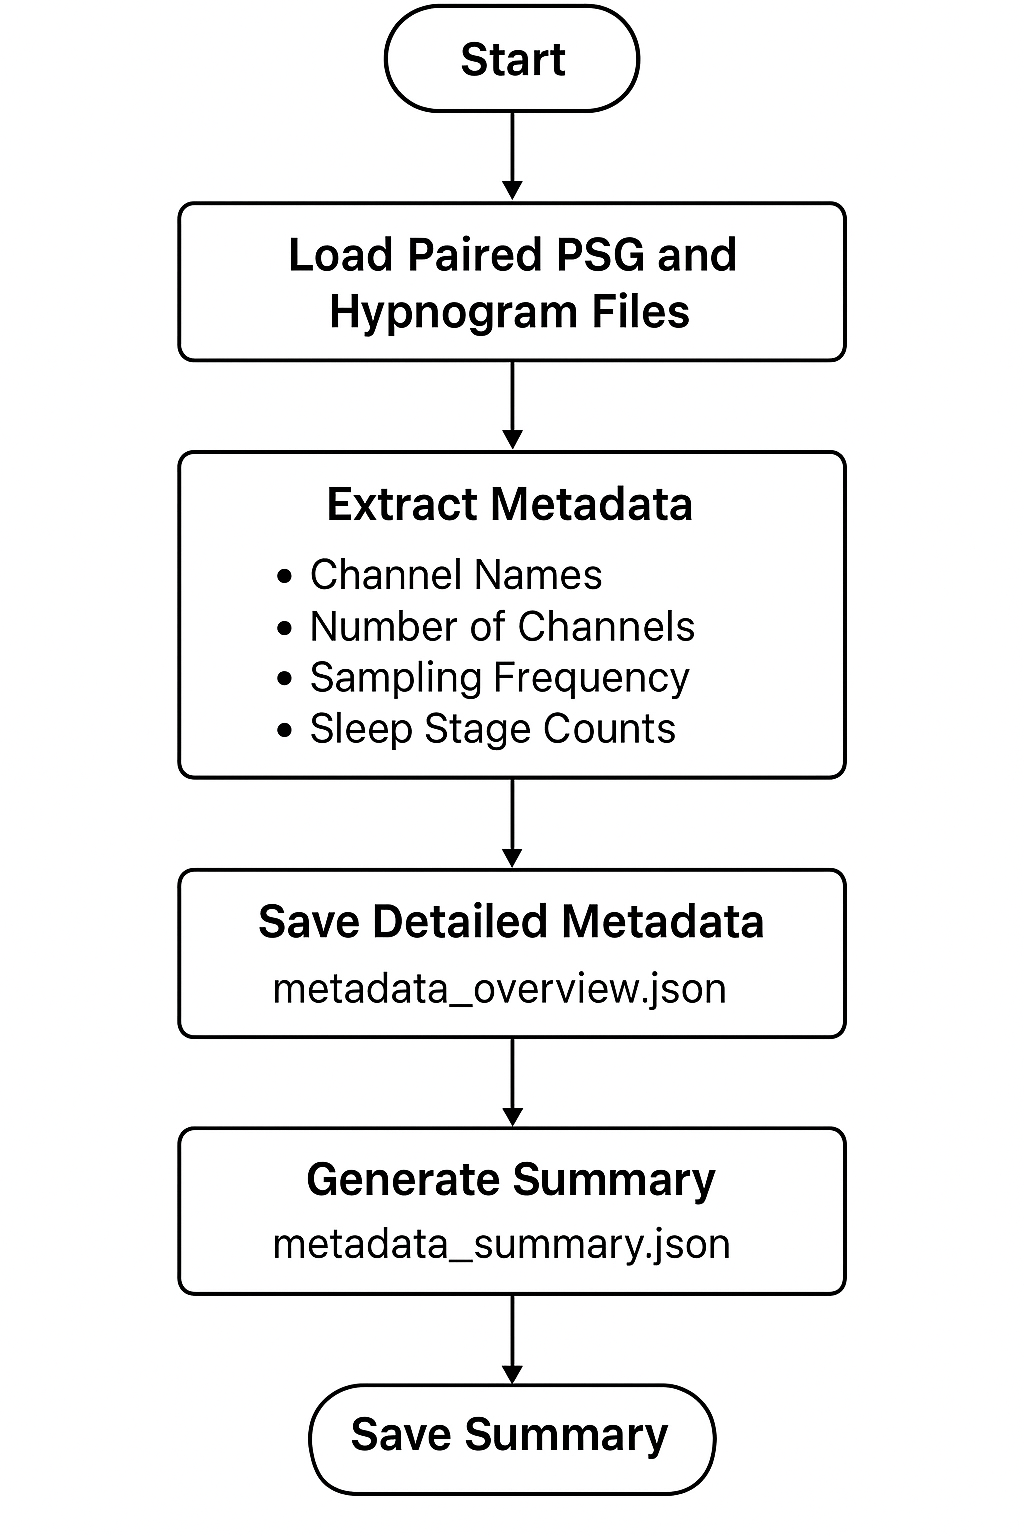

In [8]:
# Import useful libraries
import mne # read EDF files (PSG + hypnogram)
import json # load/save JSON files
from collections import Counter, defaultdict # count frequencies (sleep stages, sampling freq etc.)
from tqdm import tqdm # progress bar

# Load pairs
"""
Open paired_files.json

Load all PSG–Hypnogram matched pairs

Store them in paired_data
"""

PAIRS_FILE = BASE_DIR / "paired_files.json"
with open(PAIRS_FILE, "r") as f:
    paired_data = json.load(f)["pairs"]

# Create containers for results
overview = [] # detailed info for every record
agg_stage_counts = Counter() # total count of all sleep stages
sfreq_counter = Counter() # how often each sampling frequency appears
channel_sets = Counter() # how many unique channel combinations exist

# Loop through each pair
for pair in tqdm(paired_data, desc="Processing pairs"):
    rid = pair["record_id"]

    # Create an empty dictionary for this record(This dictionary will store all metadata about this record)
    entry = {
        "record_id": rid,
        "psg_file": pair["psg_file"],
        "hypnogram_file": pair["hypnogram_file"],
        "channels": None,
        "n_channels": None,
        "sfreq": None,
        "duration_sec": None,
        "n_annotations": None,
        "stage_counts": None,
        "subset": None,
        "error": None
    }
    try:
        # Detect which subset (cassette or telemetry)
        """
        Sleep-EDF has two subsets:

        sleep-cassette

        sleep-telemetry

        The code identifies which one the file belongs to.
        """

        if "sleep-cassette" in pair["psg_file"]:
            entry["subset"] = "sleep-cassette"
        elif "sleep-telemetry" in pair["psg_file"]:
            entry["subset"] = "sleep-telemetry"

        # Read PSG header only
        raw = mne.io.read_raw_edf(pair["psg_file"], preload=False, verbose=False) # preload=False means do NOT load the large signal data. Only metadata is read
        entry["channels"] = raw.ch_names # the list of channel names
        entry["n_channels"] = len(raw.ch_names) # number of channels
        entry["sfreq"] = raw.info.get("sfreq", None) # sampling rate (e.g., 100 Hz)
        # Update Counters
        sfreq_counter.update([entry["sfreq"]])
        channel_sets.update([tuple(raw.ch_names)])
        # Calculate the recording duration
        if raw.n_times and raw.info.get("sfreq"):
            entry["duration_sec"] = raw.n_times / raw.info["sfreq"] # Duration = number of samples ÷ sampling frequency.

        # Read hypnogram annotations
        ann = mne.read_annotations(pair["hypnogram_file"])
        entry["n_annotations"] = len(ann) # Each annotation = a sleep stage epoch.

        # Count sleep stages
        descs = list(ann.description)
        sc = dict(Counter(descs))
        entry["stage_counts"] = sc
        agg_stage_counts.update(sc)

    # Handle any errors
    # If any file is broken or unreadable, record the error.
    except Exception as e:
        entry["error"] = str(e)

    overview.append(entry) # Save this record’s info

# Save overview JSON (This file has full details for every record)
OUT_OVERVIEW = BASE_DIR / "metadata_overview.json" # Save full detailed metadata file
with open(OUT_OVERVIEW, "w") as f:
    json.dump(overview, f, indent=2)

# Aggregate summary
summary = {
    "total_records": len(overview), # (how many records)
    "sfreq_distribution": dict(sfreq_counter.most_common()), # how many sampling frequencies exist
    "top_stage_labels_overall": agg_stage_counts.most_common(), # total sleep stage counts
    "unique_channel_sets_count": len(channel_sets) # how many unique channel layouts
}

# Save Summary
OUT_SUMMARY = BASE_DIR / "metadata_summary.json"
with open(OUT_SUMMARY, "w") as f:
    json.dump(summary, f, indent=2)



Processing pairs:   0%|          | 0/197 [00:00<?, ?it/s]/tmp/ipython-input-1978416815.py:62: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=False, verbose=False) # preload=False means do NOT load the large signal data. Only metadata is read
/tmp/ipython-input-1978416815.py:62: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=False, verbose=False) # preload=False means do NOT load the large signal data. Only metadata is read
/tmp/ipython-input-1978416815.py:62: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=False, verbose=False) # preload=False means do NOT load the large signal data. Only metadata is read
Processing pairs:   1%|          | 1/197 [0

In [9]:
# Print concise summary
print("=== METADATA SUMMARY ===")
print(f"Total paired records: {summary['total_records']}")
print("Sampling frequency distribution:", summary['sfreq_distribution'])
print("Unique channel sets count:", summary['unique_channel_sets_count'])
print("Top sleep stage counts (aggregated):")
for stage, count in summary["top_stage_labels_overall"][:10]:
    print(f"  {stage}: {count}")
print("\nSaved metadata overview to:", OUT_OVERVIEW)
print("Saved metadata summary to:", OUT_SUMMARY)

=== METADATA SUMMARY ===
Total paired records: 197
Sampling frequency distribution: {100.0: 197}
Unique channel sets count: 2
Top sleep stage counts (aggregated):
  Sleep stage 2: 8171
  Sleep stage 1: 7292
  Sleep stage 3: 4820
  Sleep stage W: 4461
  Sleep stage R: 1953
  Sleep stage 4: 1462
  Movement time: 196
  Sleep stage ?: 174

Saved metadata overview to: /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/metadata_overview.json
Saved metadata summary to: /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/metadata_summary.json


# 7. Visualize Channels & Sleep Stages
Now we move to exploratory visualizations:

1. Distribution of EEG/EOG/EMG channels across dataset

2. Histogram of sleep stage counts

3. Example PSG signals for one subject

4. Hypnogram timeline plots

These will help us understand signal characteristics and class balance.

# Figure 0: Sleep Stage Distribution

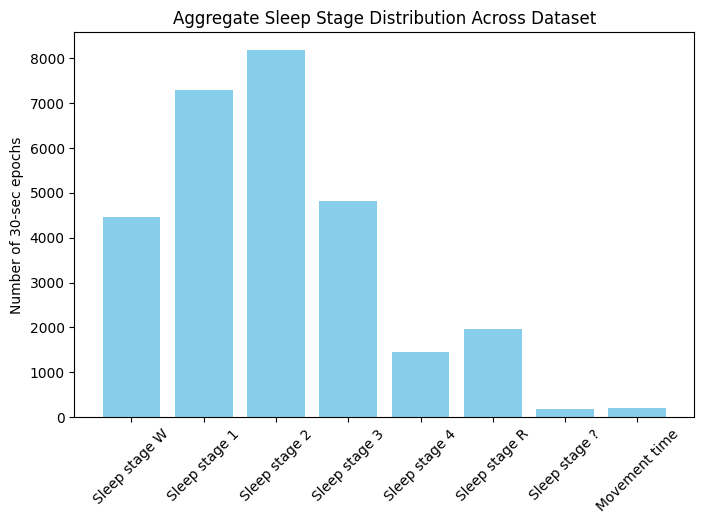

In [10]:

import matplotlib.pyplot as plt
import mne
import random
import json
from pathlib import Path

# Load metadata overview
META_FILE = BASE_DIR / "metadata_overview.json"
with open(META_FILE, "r") as f:
    metadata = json.load(f)

# Sleep stage distribution(Count total number of epochs for each stage across the whole dataset)

"""
This aggregates all hypnograms to find:

how many epochs of W, N1, N2, N3, REM

"""

stage_counts_total = {}
for rec in metadata:
    for stage, cnt in rec["stage_counts"].items():
        stage_counts_total[stage] = stage_counts_total.get(stage, 0) + cnt

# Plot the bar chart (This displays the overall sleep stage distribution)
plt.figure(figsize=(8,5))
plt.bar(stage_counts_total.keys(), stage_counts_total.values(), color='skyblue')
plt.title("Aggregate Sleep Stage Distribution Across Dataset")
plt.ylabel("Number of 30-sec epochs")
plt.xticks(rotation=45)
plt.show()

# Figure 1: Channel Configuration Distribution

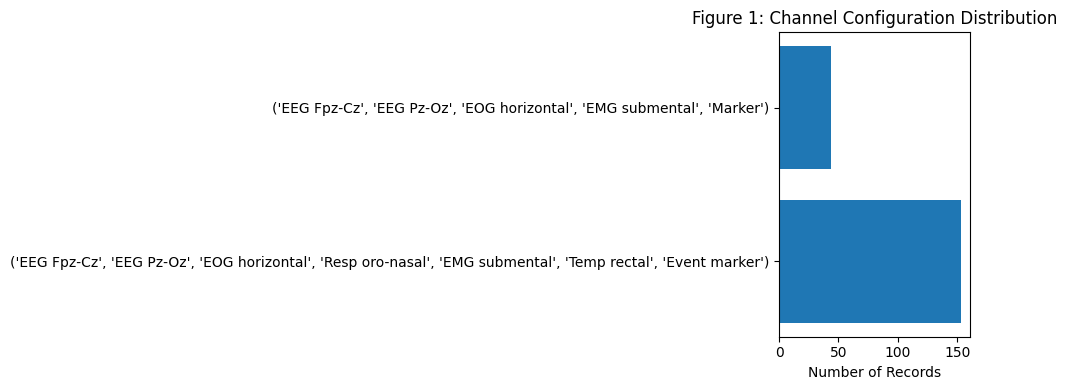

In [11]:

# FIGURE 1 — Channel Configuration Distribution
channel_counter = {}
for rec in metadata:
    chs = tuple(rec["channels"])
    channel_counter[chs] = channel_counter.get(chs, 0) + 1

plt.figure(figsize=(10, 4))

configs = [str(k) for k in channel_counter.keys()]
counts = list(channel_counter.values())

plt.barh(configs, counts)
plt.xlabel("Number of Records")
plt.title("Figure 1: Channel Configuration Distribution")
plt.tight_layout()
plt.show()


# Figure 2: PSG Raw Signal Plot (Single Subject)

Selected Subject: ST7102J


/tmp/ipython-input-970532480.py:5: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(example_rec["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-970532480.py:5: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(example_rec["psg_file"], preload=True, verbose=False)


Using matplotlib as 2D backend.


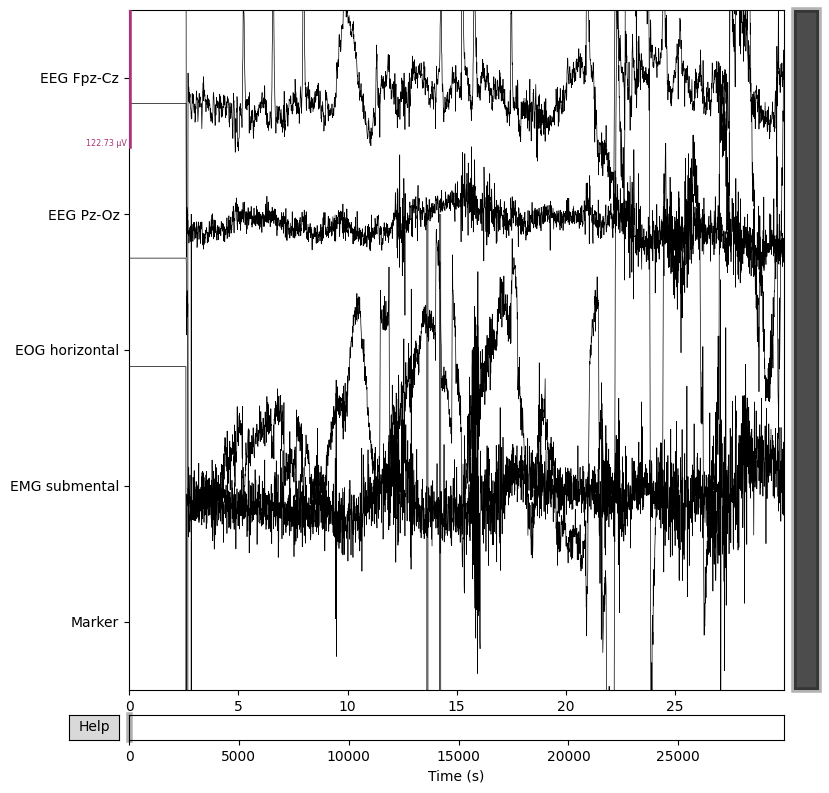

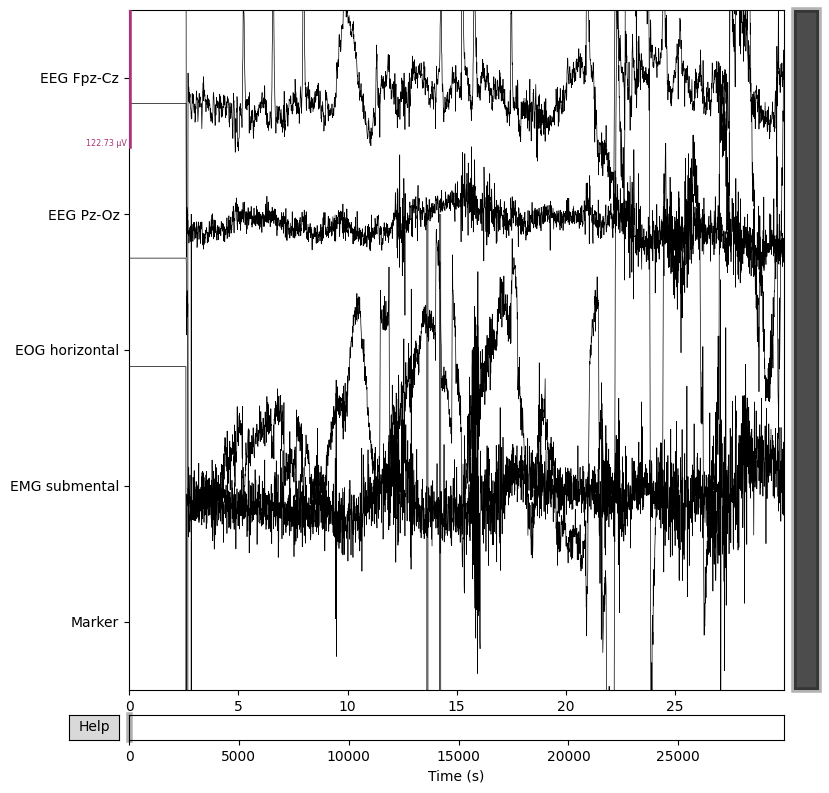

In [12]:
# FIGURE 2 — Example PSG Signal
example_rec = random.choice(metadata)
print(f"Selected Subject: {example_rec['record_id']}")

raw = mne.io.read_raw_edf(example_rec["psg_file"], preload=True, verbose=False)

raw.plot(
    n_channels=len(raw.ch_names),
    duration=30,
    scalings='auto',
    show=True,
    title=f"Figure 2: PSG Signal Example - {example_rec['record_id']}"
)


# Figure 3: Hypnogram Plot (Same Subject)

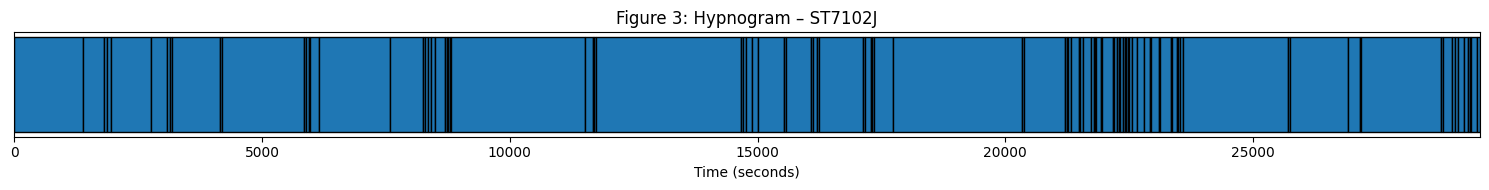

In [13]:

# FIGURE 3 — Hypnogram

ann = mne.read_annotations(example_rec["hypnogram_file"])

onsets = ann.onset
durations = ann.duration
stages = ann.description

plt.figure(figsize=(15, 2))

for onset, dur, stage in zip(onsets, durations, stages):
    plt.barh(
        0,
        width=dur,
        left=onset,
        height=0.5,
        edgecolor='black',
        color='tab:blue'
    )

plt.yticks([])
plt.xlabel("Time (seconds)")
plt.title(f"Figure 3: Hypnogram – {example_rec['record_id']}")
plt.xlim(0, sum(durations))
plt.tight_layout()
plt.show()


# 8. Sleep EEG preprocessing and epoching pipeline

In [14]:
import numpy as np
import mne
from pathlib import Path
import json
from tqdm import tqdm

# Base directory and output path
BASE_DIR = Path("/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0")
OUTPUT_DIR = BASE_DIR / "preprocessed"
OUTPUT_DIR.mkdir(exist_ok=True) # Ensures no error if folder already exists

# Load the PSG–Hypnogram Pairing File
PAIRS_FILE = BASE_DIR / "paired_files.json" # contains the list of matching PSG + hypnogram files
with open(PAIRS_FILE, "r") as f:
    paired_data = json.load(f)["pairs"] # This ensures you always process the correct matching files

# Standard channels for modeling
EEG_CHANNELS = ['Fpz-Cz', 'Pz-Oz']  # Classic Sleep-EDF EEG channels
EOG_CHANNELS = ['EOG horizontal']   # Eye Movement
EMG_CHANNELS = ['EMG submental']    # Muscle Tension

# Sleep stage mapping(Labels --> Numbers)
# This converts textual sleep labels into integers
STAGE_MAPPING = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,  # merge N3/N4
    'Sleep stage R': 4
}

# Parameters (Define Constants)
EPOCH_SEC = 30  # standard 30-second epochs
SFREQ = 100     # sampling rate 100(Hz) common for training ML models

# Loop over each paired record
for pair in tqdm(paired_data, desc="Preprocessing PSGs"):
    rid = pair["record_id"]
    try:
        # Load raw signal
        raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)

        # Select channels (we selectd only EEG + EOG + EMG)
        channels_to_use = [ch for ch in raw.ch_names if ch in EEG_CHANNELS + EOG_CHANNELS + EMG_CHANNELS]
        raw.pick_channels(channels_to_use)

        # Apply bandpass filter
        raw.filter(l_freq=0.5, h_freq=30, fir_design='firwin', verbose=False)  # EEG/EOG
        # EMG filtering can be done separately if needed

        # Save filtered raw object for inspection (optional)
        raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)

    except Exception as e:
        print(f"Error preprocessing {rid}: {e}")


Preprocessing PSGs:   0%|          | 0/197 [00:00<?, ?it/s]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4001E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4001E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4001E-filtered.fif
[done]


Preprocessing PSGs:   1%|          | 1/197 [00:07<24:42,  7.56s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4002E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4002E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4002E-filtered.fif
[done]


Preprocessing PSGs:   1%|          | 2/197 [00:16<26:25,  8.13s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4011E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4011E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4011E-filtered.fif
[done]


Preprocessing PSGs:   2%|▏         | 3/197 [00:24<26:04,  8.06s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4012E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4012E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4012E-filtered.fif
[done]


Preprocessing PSGs:   2%|▏         | 4/197 [00:31<24:46,  7.70s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4021E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4021E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4021E-filtered.fif
[done]


Preprocessing PSGs:   3%|▎         | 5/197 [00:40<26:54,  8.41s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4022E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4022E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4022E-filtered.fif
[done]


Preprocessing PSGs:   3%|▎         | 6/197 [00:47<24:28,  7.69s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4031E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4031E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4031E-filtered.fif
[done]


Preprocessing PSGs:   4%|▎         | 7/197 [00:53<23:17,  7.36s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4032E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4032E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4032E-filtered.fif
[done]


Preprocessing PSGs:   4%|▍         | 8/197 [01:03<25:29,  8.09s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4041E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4041E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4041E-filtered.fif
[done]


Preprocessing PSGs:   5%|▍         | 9/197 [01:10<24:00,  7.66s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4042E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4042E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4042E-filtered.fif
[done]


Preprocessing PSGs:   5%|▌         | 10/197 [01:18<24:37,  7.90s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4051E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4051E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4051E-filtered.fif
[done]


Preprocessing PSGs:   6%|▌         | 11/197 [01:31<28:54,  9.33s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4052E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4052E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4052E-filtered.fif
[done]


Preprocessing PSGs:   6%|▌         | 12/197 [01:39<27:45,  9.00s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4061E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4061E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4061E-filtered.fif
[done]


Preprocessing PSGs:   7%|▋         | 13/197 [01:47<26:27,  8.63s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4062E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4062E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4062E-filtered.fif
[done]


Preprocessing PSGs:   7%|▋         | 14/197 [01:55<26:04,  8.55s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4071E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4071E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4071E-filtered.fif
[done]


Preprocessing PSGs:   8%|▊         | 15/197 [02:03<25:37,  8.45s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4072E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4072E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4072E-filtered.fif
[done]


Preprocessing PSGs:   8%|▊         | 16/197 [02:11<25:04,  8.31s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4081E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4081E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4081E-filtered.fif
[done]


Preprocessing PSGs:   9%|▊         | 17/197 [02:19<24:24,  8.14s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4082E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4082E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4082E-filtered.fif
[done]


Preprocessing PSGs:   9%|▉         | 18/197 [02:27<24:08,  8.09s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4091E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4091E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4091E-filtered.fif
[done]


Preprocessing PSGs:  10%|▉         | 19/197 [02:37<25:48,  8.70s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4092E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4092E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4092E-filtered.fif
[done]


Preprocessing PSGs:  10%|█         | 20/197 [02:49<28:40,  9.72s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4101E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4101E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4101E-filtered.fif
[done]


Preprocessing PSGs:  11%|█         | 21/197 [02:56<25:37,  8.73s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4102E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4102E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4102E-filtered.fif
[done]


Preprocessing PSGs:  11%|█         | 22/197 [03:09<29:28, 10.11s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4111E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4111E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4111E-filtered.fif
[done]


Preprocessing PSGs:  12%|█▏        | 23/197 [03:20<30:26, 10.50s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4112E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4112E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4112E-filtered.fif
[done]


Preprocessing PSGs:  12%|█▏        | 24/197 [03:28<27:32,  9.55s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4121E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4121E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4121E-filtered.fif
[done]


Preprocessing PSGs:  13%|█▎        | 25/197 [03:36<25:58,  9.06s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4122E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4122E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4122E-filtered.fif
[done]


Preprocessing PSGs:  13%|█▎        | 26/197 [03:46<27:02,  9.49s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4131E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4131E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4131E-filtered.fif
[done]


Preprocessing PSGs:  14%|█▎        | 27/197 [03:53<24:32,  8.66s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4141E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4141E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4141E-filtered.fif
[done]


Preprocessing PSGs:  14%|█▍        | 28/197 [04:00<23:09,  8.22s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4142E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4142E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4142E-filtered.fif
[done]


Preprocessing PSGs:  15%|█▍        | 29/197 [04:07<22:12,  7.93s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4151E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4151E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4151E-filtered.fif
[done]


Preprocessing PSGs:  15%|█▌        | 30/197 [04:13<20:27,  7.35s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4152E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4152E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4152E-filtered.fif
[done]


Preprocessing PSGs:  16%|█▌        | 31/197 [04:21<20:24,  7.38s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4161E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4161E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4161E-filtered.fif
[done]


Preprocessing PSGs:  16%|█▌        | 32/197 [04:27<19:31,  7.10s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4162E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4162E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4162E-filtered.fif
[done]


Preprocessing PSGs:  17%|█▋        | 33/197 [04:35<19:47,  7.24s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4171E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4171E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4171E-filtered.fif
[done]


Preprocessing PSGs:  17%|█▋        | 34/197 [04:42<19:49,  7.30s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4172E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4172E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4172E-filtered.fif
[done]


Preprocessing PSGs:  18%|█▊        | 35/197 [04:51<20:54,  7.74s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4181E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4181E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4181E-filtered.fif
[done]


Preprocessing PSGs:  18%|█▊        | 36/197 [04:58<19:57,  7.44s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4182E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4182E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4182E-filtered.fif
[done]


Preprocessing PSGs:  19%|█▉        | 37/197 [05:05<19:55,  7.47s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4191E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4191E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4191E-filtered.fif
[done]


Preprocessing PSGs:  19%|█▉        | 38/197 [05:12<19:00,  7.17s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4192E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4192E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4192E-filtered.fif
[done]


Preprocessing PSGs:  20%|█▉        | 39/197 [05:19<19:08,  7.27s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4201E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4201E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4201E-filtered.fif
[done]


Preprocessing PSGs:  20%|██        | 40/197 [05:30<21:33,  8.24s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4202E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4202E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4202E-filtered.fif
[done]


Preprocessing PSGs:  21%|██        | 41/197 [05:36<19:57,  7.68s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4211E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4211E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4211E-filtered.fif
[done]


Preprocessing PSGs:  21%|██▏       | 42/197 [05:44<20:20,  7.87s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4212E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4212E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4212E-filtered.fif
[done]


Preprocessing PSGs:  22%|██▏       | 43/197 [05:53<20:34,  8.01s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4221E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4221E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4221E-filtered.fif
[done]


Preprocessing PSGs:  22%|██▏       | 44/197 [06:00<19:58,  7.83s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4222E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4222E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4222E-filtered.fif
[done]


Preprocessing PSGs:  23%|██▎       | 45/197 [06:07<19:09,  7.56s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4231E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4231E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4231E-filtered.fif
[done]


Preprocessing PSGs:  23%|██▎       | 46/197 [06:19<22:08,  8.80s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4232E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4232E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4232E-filtered.fif
[done]


Preprocessing PSGs:  24%|██▍       | 47/197 [06:26<20:41,  8.28s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4241E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4241E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4241E-filtered.fif
[done]


Preprocessing PSGs:  24%|██▍       | 48/197 [06:34<20:37,  8.31s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4242E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4242E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4242E-filtered.fif
[done]


Preprocessing PSGs:  25%|██▍       | 49/197 [06:42<20:18,  8.23s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4251E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4251E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4251E-filtered.fif
[done]


Preprocessing PSGs:  25%|██▌       | 50/197 [06:49<19:08,  7.81s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4252E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4252E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4252E-filtered.fif
[done]


Preprocessing PSGs:  26%|██▌       | 51/197 [06:57<19:07,  7.86s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4261F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4261F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4261F-filtered.fif
[done]


Preprocessing PSGs:  26%|██▋       | 52/197 [07:04<18:38,  7.71s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4262F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4262F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4262F-filtered.fif
[done]


Preprocessing PSGs:  27%|██▋       | 53/197 [07:11<17:27,  7.28s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4271F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4271F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4271F-filtered.fif
[done]


Preprocessing PSGs:  27%|██▋       | 54/197 [07:17<16:31,  6.93s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4272F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4272F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4272F-filtered.fif
[done]


Preprocessing PSGs:  28%|██▊       | 55/197 [07:24<16:49,  7.11s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4281G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4281G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4281G-filtered.fif
[done]


Preprocessing PSGs:  28%|██▊       | 56/197 [07:32<16:58,  7.22s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4282G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4282G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4282G-filtered.fif
[done]


Preprocessing PSGs:  29%|██▉       | 57/197 [07:40<17:23,  7.45s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4291G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4291G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4291G-filtered.fif
[done]


Preprocessing PSGs:  29%|██▉       | 58/197 [07:48<17:26,  7.53s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4292G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4292G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4292G-filtered.fif
[done]


Preprocessing PSGs:  30%|██▉       | 59/197 [07:56<17:39,  7.68s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4301E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4301E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4301E-filtered.fif
[done]


Preprocessing PSGs:  30%|███       | 60/197 [08:03<17:17,  7.58s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4302E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4302E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4302E-filtered.fif
[done]


Preprocessing PSGs:  31%|███       | 61/197 [08:10<16:59,  7.49s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4311E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4311E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4311E-filtered.fif
[done]


Preprocessing PSGs:  31%|███▏      | 62/197 [08:17<16:10,  7.19s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4312E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4312E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4312E-filtered.fif
[done]


Preprocessing PSGs:  32%|███▏      | 63/197 [08:24<16:14,  7.28s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4321E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4321E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4321E-filtered.fif
[done]


Preprocessing PSGs:  32%|███▏      | 64/197 [08:32<16:18,  7.36s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4322E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4322E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4322E-filtered.fif
[done]


Preprocessing PSGs:  33%|███▎      | 65/197 [08:38<15:33,  7.07s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4331F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4331F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4331F-filtered.fif
[done]


Preprocessing PSGs:  34%|███▎      | 66/197 [08:46<15:55,  7.29s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4332F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4332F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4332F-filtered.fif
[done]


Preprocessing PSGs:  34%|███▍      | 67/197 [08:54<15:58,  7.38s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4341F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4341F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4341F-filtered.fif
[done]


Preprocessing PSGs:  35%|███▍      | 68/197 [09:01<16:10,  7.53s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4342F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4342F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4342F-filtered.fif
[done]


Preprocessing PSGs:  35%|███▌      | 69/197 [09:09<16:16,  7.63s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4351F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4351F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4351F-filtered.fif
[done]


Preprocessing PSGs:  36%|███▌      | 70/197 [09:19<17:28,  8.25s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4352F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4352F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4352F-filtered.fif
[done]


Preprocessing PSGs:  36%|███▌      | 71/197 [09:27<16:57,  8.08s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4362F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4362F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4362F-filtered.fif
[done]


Preprocessing PSGs:  37%|███▋      | 72/197 [09:33<15:27,  7.42s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4371F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4371F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4371F-filtered.fif
[done]


Preprocessing PSGs:  37%|███▋      | 73/197 [09:40<15:37,  7.56s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4372F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4372F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4372F-filtered.fif
[done]


Preprocessing PSGs:  38%|███▊      | 74/197 [09:48<15:12,  7.42s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4381F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4381F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4381F-filtered.fif
[done]


Preprocessing PSGs:  38%|███▊      | 75/197 [09:54<14:46,  7.27s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4382F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4382F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4382F-filtered.fif
[done]


Preprocessing PSGs:  39%|███▊      | 76/197 [10:04<15:46,  7.82s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4401E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4401E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4401E-filtered.fif
[done]


Preprocessing PSGs:  39%|███▉      | 77/197 [10:12<15:55,  7.96s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4402E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4402E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4402E-filtered.fif
[done]


Preprocessing PSGs:  40%|███▉      | 78/197 [10:18<14:38,  7.38s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4411E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4411E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4411E-filtered.fif
[done]


Preprocessing PSGs:  40%|████      | 79/197 [10:25<14:10,  7.21s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4412E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4412E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4412E-filtered.fif
[done]


Preprocessing PSGs:  41%|████      | 80/197 [10:38<17:26,  8.95s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4421E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4421E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4421E-filtered.fif
[done]


Preprocessing PSGs:  41%|████      | 81/197 [10:48<17:58,  9.30s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4422E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4422E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4422E-filtered.fif
[done]


Preprocessing PSGs:  42%|████▏     | 82/197 [10:55<16:27,  8.59s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4431E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4431E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4431E-filtered.fif
[done]


Preprocessing PSGs:  42%|████▏     | 83/197 [11:04<16:28,  8.67s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4432E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4432E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4432E-filtered.fif
[done]


Preprocessing PSGs:  43%|████▎     | 84/197 [11:11<15:20,  8.15s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4441E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4441E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4441E-filtered.fif
[done]


Preprocessing PSGs:  43%|████▎     | 85/197 [11:19<15:17,  8.19s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4442E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4442E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4442E-filtered.fif
[done]


Preprocessing PSGs:  44%|████▎     | 86/197 [11:27<15:20,  8.29s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4451F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4451F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4451F-filtered.fif
[done]


Preprocessing PSGs:  44%|████▍     | 87/197 [11:35<14:49,  8.09s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4452F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4452F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4452F-filtered.fif
[done]


Preprocessing PSGs:  45%|████▍     | 88/197 [11:43<14:41,  8.09s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4461F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4461F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4461F-filtered.fif
[done]


Preprocessing PSGs:  45%|████▌     | 89/197 [11:50<13:46,  7.65s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4462F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4462F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4462F-filtered.fif
[done]


Preprocessing PSGs:  46%|████▌     | 90/197 [11:57<13:14,  7.43s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4471F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4471F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4471F-filtered.fif
[done]


Preprocessing PSGs:  46%|████▌     | 91/197 [12:04<13:08,  7.43s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4472F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4472F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4472F-filtered.fif
[done]


Preprocessing PSGs:  47%|████▋     | 92/197 [12:12<13:26,  7.68s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4481F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4481F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4481F-filtered.fif
[done]


Preprocessing PSGs:  47%|████▋     | 93/197 [12:21<13:51,  7.99s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4482F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4482F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4482F-filtered.fif
[done]


Preprocessing PSGs:  48%|████▊     | 94/197 [12:28<13:07,  7.65s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4491G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4491G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4491G-filtered.fif
[done]


Preprocessing PSGs:  48%|████▊     | 95/197 [12:36<13:12,  7.77s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4492G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4492G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4492G-filtered.fif
[done]


Preprocessing PSGs:  49%|████▊     | 96/197 [12:42<12:20,  7.33s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4501E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4501E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4501E-filtered.fif
[done]


Preprocessing PSGs:  49%|████▉     | 97/197 [12:48<11:26,  6.87s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4502E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4502E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4502E-filtered.fif
[done]


Preprocessing PSGs:  50%|████▉     | 98/197 [12:57<12:30,  7.59s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4511E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4511E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4511E-filtered.fif
[done]


Preprocessing PSGs:  50%|█████     | 99/197 [13:04<12:09,  7.44s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4512E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4512E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4512E-filtered.fif
[done]


Preprocessing PSGs:  51%|█████     | 100/197 [13:11<11:49,  7.31s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4522E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4522E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4522E-filtered.fif
[done]


Preprocessing PSGs:  51%|█████▏    | 101/197 [13:19<11:40,  7.30s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4531E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4531E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4531E-filtered.fif
[done]


Preprocessing PSGs:  52%|█████▏    | 102/197 [13:30<13:42,  8.66s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4532E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4532E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4532E-filtered.fif
[done]


Preprocessing PSGs:  52%|█████▏    | 103/197 [13:37<12:46,  8.15s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4541F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4541F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4541F-filtered.fif
[done]


Preprocessing PSGs:  53%|█████▎    | 104/197 [13:45<12:17,  7.93s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4542F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4542F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4542F-filtered.fif
[done]


Preprocessing PSGs:  53%|█████▎    | 105/197 [13:53<12:19,  8.04s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4551F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4551F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4551F-filtered.fif
[done]


Preprocessing PSGs:  54%|█████▍    | 106/197 [14:01<12:09,  8.01s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4552F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4552F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4552F-filtered.fif
[done]


Preprocessing PSGs:  54%|█████▍    | 107/197 [14:09<11:56,  7.97s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4561F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4561F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4561F-filtered.fif
[done]


Preprocessing PSGs:  55%|█████▍    | 108/197 [14:16<11:33,  7.79s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4562F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4562F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4562F-filtered.fif
[done]


Preprocessing PSGs:  55%|█████▌    | 109/197 [14:23<10:47,  7.36s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4571F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4571F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4571F-filtered.fif
[done]


Preprocessing PSGs:  56%|█████▌    | 110/197 [14:30<10:38,  7.34s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4572F-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4572F-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4572F-filtered.fif
[done]


Preprocessing PSGs:  56%|█████▋    | 111/197 [14:38<10:45,  7.50s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4581G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4581G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4581G-filtered.fif
[done]


Preprocessing PSGs:  57%|█████▋    | 112/197 [14:44<10:02,  7.09s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4582G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4582G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4582G-filtered.fif
[done]


Preprocessing PSGs:  57%|█████▋    | 113/197 [14:52<10:26,  7.46s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4591G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4591G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4591G-filtered.fif
[done]


Preprocessing PSGs:  58%|█████▊    | 114/197 [15:00<10:12,  7.38s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4592G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4592G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4592G-filtered.fif
[done]


Preprocessing PSGs:  58%|█████▊    | 115/197 [15:05<09:10,  6.71s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4601E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4601E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4601E-filtered.fif
[done]


Preprocessing PSGs:  59%|█████▉    | 116/197 [15:11<08:52,  6.57s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4602E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4602E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4602E-filtered.fif
[done]


Preprocessing PSGs:  59%|█████▉    | 117/197 [15:18<09:08,  6.86s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4611E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4611E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4611E-filtered.fif
[done]


Preprocessing PSGs:  60%|█████▉    | 118/197 [15:25<08:54,  6.76s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4612E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4612E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4612E-filtered.fif
[done]


Preprocessing PSGs:  60%|██████    | 119/197 [15:33<09:21,  7.19s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4621E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4621E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4621E-filtered.fif
[done]


Preprocessing PSGs:  61%|██████    | 120/197 [15:41<09:33,  7.44s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4622E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4622E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4622E-filtered.fif
[done]


Preprocessing PSGs:  61%|██████▏   | 121/197 [15:48<09:18,  7.35s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4631E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4631E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4631E-filtered.fif
[done]


Preprocessing PSGs:  62%|██████▏   | 122/197 [15:56<09:13,  7.38s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4632E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4632E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4632E-filtered.fif
[done]


Preprocessing PSGs:  62%|██████▏   | 123/197 [16:04<09:29,  7.70s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4641E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4641E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4641E-filtered.fif
[done]


Preprocessing PSGs:  63%|██████▎   | 124/197 [16:11<08:58,  7.37s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4642E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4642E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4642E-filtered.fif
[done]


Preprocessing PSGs:  63%|██████▎   | 125/197 [16:18<08:35,  7.16s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4651E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4651E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4651E-filtered.fif
[done]


Preprocessing PSGs:  64%|██████▍   | 126/197 [16:24<08:12,  6.93s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4652E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4652E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4652E-filtered.fif
[done]


Preprocessing PSGs:  64%|██████▍   | 127/197 [16:32<08:31,  7.30s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4661E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4661E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4661E-filtered.fif
[done]


Preprocessing PSGs:  65%|██████▍   | 128/197 [16:40<08:35,  7.46s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4662E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4662E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4662E-filtered.fif
[done]


Preprocessing PSGs:  65%|██████▌   | 129/197 [16:48<08:30,  7.51s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4671G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4671G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4671G-filtered.fif
[done]


Preprocessing PSGs:  66%|██████▌   | 130/197 [16:56<08:34,  7.68s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4672G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4672G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4672G-filtered.fif
[done]


Preprocessing PSGs:  66%|██████▋   | 131/197 [17:02<08:07,  7.38s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4701E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4701E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4701E-filtered.fif
[done]


Preprocessing PSGs:  67%|██████▋   | 132/197 [17:10<08:01,  7.40s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4702E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4702E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4702E-filtered.fif
[done]


Preprocessing PSGs:  68%|██████▊   | 133/197 [17:16<07:39,  7.18s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4711E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4711E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4711E-filtered.fif
[done]


Preprocessing PSGs:  68%|██████▊   | 134/197 [17:24<07:48,  7.44s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4712E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4712E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4712E-filtered.fif
[done]


Preprocessing PSGs:  69%|██████▊   | 135/197 [17:33<07:54,  7.65s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4721E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4721E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4721E-filtered.fif
[done]


Preprocessing PSGs:  69%|██████▉   | 136/197 [17:43<08:29,  8.35s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4722E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4722E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4722E-filtered.fif
[done]


Preprocessing PSGs:  70%|██████▉   | 137/197 [17:55<09:31,  9.53s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4731E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4731E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4731E-filtered.fif
[done]


Preprocessing PSGs:  70%|███████   | 138/197 [18:03<08:49,  8.97s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4732E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4732E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4732E-filtered.fif
[done]


Preprocessing PSGs:  71%|███████   | 139/197 [18:10<08:13,  8.50s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4741E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4741E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4741E-filtered.fif
[done]


Preprocessing PSGs:  71%|███████   | 140/197 [18:19<08:06,  8.53s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4742E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4742E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4742E-filtered.fif
[done]


Preprocessing PSGs:  72%|███████▏  | 141/197 [18:26<07:46,  8.33s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4751E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4751E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4751E-filtered.fif
[done]


Preprocessing PSGs:  72%|███████▏  | 142/197 [18:35<07:50,  8.55s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4752E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4752E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4752E-filtered.fif
[done]


Preprocessing PSGs:  73%|███████▎  | 143/197 [18:42<07:05,  7.88s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4761E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4761E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4761E-filtered.fif
[done]


Preprocessing PSGs:  73%|███████▎  | 144/197 [18:50<07:09,  8.11s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4762E-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4762E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4762E-filtered.fif
[done]


Preprocessing PSGs:  74%|███████▎  | 145/197 [18:59<07:02,  8.12s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4771G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4771G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4771G-filtered.fif
[done]


Preprocessing PSGs:  74%|███████▍  | 146/197 [19:06<06:48,  8.01s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4772G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4772G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4772G-filtered.fif
[done]


Preprocessing PSGs:  75%|███████▍  | 147/197 [19:13<06:17,  7.54s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4801G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4801G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4801G-filtered.fif
[done]


Preprocessing PSGs:  75%|███████▌  | 148/197 [19:21<06:15,  7.67s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4802G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4802G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4802G-filtered.fif
[done]


Preprocessing PSGs:  76%|███████▌  | 149/197 [19:29<06:19,  7.90s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4811G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4811G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4811G-filtered.fif
[done]


Preprocessing PSGs:  76%|███████▌  | 150/197 [19:41<07:01,  8.97s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4812G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4812G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4812G-filtered.fif
[done]


Preprocessing PSGs:  77%|███████▋  | 151/197 [19:47<06:21,  8.29s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4821G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4821G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4821G-filtered.fif
[done]


Preprocessing PSGs:  77%|███████▋  | 152/197 [19:59<06:59,  9.32s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4822G-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4822G-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4822G-filtered.fif
[done]


Preprocessing PSGs:  78%|███████▊  | 153/197 [20:07<06:30,  8.87s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7011J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7011J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7011J-filtered.fif
[done]


Preprocessing PSGs:  78%|███████▊  | 154/197 [20:10<05:09,  7.19s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7012J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7012J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7012J-filtered.fif
[done]


Preprocessing PSGs:  79%|███████▊  | 155/197 [20:14<04:19,  6.18s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7021J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7021J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7021J-filtered.fif
[done]


Preprocessing PSGs:  79%|███████▉  | 156/197 [20:17<03:38,  5.33s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7022J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7022J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7022J-filtered.fif
[done]


Preprocessing PSGs:  80%|███████▉  | 157/197 [20:21<03:08,  4.72s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7041J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7041J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7041J-filtered.fif
[done]


Preprocessing PSGs:  80%|████████  | 158/197 [20:24<02:47,  4.29s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7042J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7042J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7042J-filtered.fif
[done]


Preprocessing PSGs:  81%|████████  | 159/197 [20:28<02:38,  4.17s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7051J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7051J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7051J-filtered.fif
[done]


Preprocessing PSGs:  81%|████████  | 160/197 [20:31<02:25,  3.93s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7052J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7052J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7052J-filtered.fif
[done]


Preprocessing PSGs:  82%|████████▏ | 161/197 [20:35<02:17,  3.83s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7061J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7061J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7061J-filtered.fif
[done]


Preprocessing PSGs:  82%|████████▏ | 162/197 [20:39<02:14,  3.85s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7062J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7062J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7062J-filtered.fif
[done]


Preprocessing PSGs:  83%|████████▎ | 163/197 [20:42<02:03,  3.65s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7071J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7071J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7071J-filtered.fif
[done]


Preprocessing PSGs:  83%|████████▎ | 164/197 [20:45<01:55,  3.51s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7072J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7072J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7072J-filtered.fif
[done]


Preprocessing PSGs:  84%|████████▍ | 165/197 [20:49<01:52,  3.52s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7081J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7081J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7081J-filtered.fif
[done]


Preprocessing PSGs:  84%|████████▍ | 166/197 [20:52<01:48,  3.49s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7082J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7082J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7082J-filtered.fif
[done]


Preprocessing PSGs:  85%|████████▍ | 167/197 [20:55<01:40,  3.36s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7091J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7091J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7091J-filtered.fif
[done]


Preprocessing PSGs:  85%|████████▌ | 168/197 [20:59<01:44,  3.61s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7092J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7092J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7092J-filtered.fif
[done]


Preprocessing PSGs:  86%|████████▌ | 169/197 [21:03<01:43,  3.68s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7101J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7101J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7101J-filtered.fif
[done]


Preprocessing PSGs:  86%|████████▋ | 170/197 [21:06<01:36,  3.56s/it]

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7102J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7102J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7102J-filtered.fif
[done]


Preprocessing PSGs:  87%|████████▋ | 171/197 [21:09<01:23,  3.23s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7111J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7111J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7111J-filtered.fif
[done]


Preprocessing PSGs:  87%|████████▋ | 172/197 [21:12<01:18,  3.15s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7112J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7112J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7112J-filtered.fif
[done]


Preprocessing PSGs:  88%|████████▊ | 173/197 [21:16<01:21,  3.41s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7121J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7121J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7121J-filtered.fif
[done]


Preprocessing PSGs:  88%|████████▊ | 174/197 [21:19<01:17,  3.39s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7122J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7122J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7122J-filtered.fif
[done]


Preprocessing PSGs:  89%|████████▉ | 175/197 [21:22<01:13,  3.36s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7131J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7131J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7131J-filtered.fif
[done]


Preprocessing PSGs:  89%|████████▉ | 176/197 [21:26<01:12,  3.45s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7132J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7132J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7132J-filtered.fif
[done]


Preprocessing PSGs:  90%|████████▉ | 177/197 [21:29<01:05,  3.27s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7141J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7141J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7141J-filtered.fif
[done]


Preprocessing PSGs:  90%|█████████ | 178/197 [21:32<01:02,  3.30s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7142J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7142J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7142J-filtered.fif
[done]


Preprocessing PSGs:  91%|█████████ | 179/197 [21:35<00:58,  3.25s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7151J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7151J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7151J-filtered.fif
[done]


Preprocessing PSGs:  91%|█████████▏| 180/197 [21:40<01:00,  3.55s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7152J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7152J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7152J-filtered.fif
[done]


Preprocessing PSGs:  92%|█████████▏| 181/197 [21:43<00:56,  3.51s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7161J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7161J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7161J-filtered.fif
[done]


Preprocessing PSGs:  92%|█████████▏| 182/197 [21:47<00:52,  3.48s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7162J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7162J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7162J-filtered.fif
[done]


Preprocessing PSGs:  93%|█████████▎| 183/197 [21:50<00:48,  3.50s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7171J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7171J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7171J-filtered.fif
[done]


Preprocessing PSGs:  93%|█████████▎| 184/197 [21:53<00:44,  3.39s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7172J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7172J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7172J-filtered.fif
[done]


Preprocessing PSGs:  94%|█████████▍| 185/197 [21:56<00:40,  3.34s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7181J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7181J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7181J-filtered.fif
[done]


Preprocessing PSGs:  94%|█████████▍| 186/197 [22:00<00:36,  3.35s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7182J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7182J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7182J-filtered.fif
[done]


Preprocessing PSGs:  95%|█████████▍| 187/197 [22:04<00:35,  3.52s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7191J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7191J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7191J-filtered.fif
[done]


Preprocessing PSGs:  95%|█████████▌| 188/197 [22:07<00:31,  3.45s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7192J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7192J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7192J-filtered.fif
[done]


Preprocessing PSGs:  96%|█████████▌| 189/197 [22:11<00:27,  3.49s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7201J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7201J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7201J-filtered.fif
[done]


Preprocessing PSGs:  96%|█████████▋| 190/197 [22:14<00:24,  3.53s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7202J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7202J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7202J-filtered.fif
[done]


Preprocessing PSGs:  97%|█████████▋| 191/197 [22:18<00:21,  3.53s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7211J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7211J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7211J-filtered.fif
[done]


Preprocessing PSGs:  97%|█████████▋| 192/197 [22:21<00:17,  3.49s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7212J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7212J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7212J-filtered.fif
[done]


Preprocessing PSGs:  98%|█████████▊| 193/197 [22:25<00:14,  3.51s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7221J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7221J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7221J-filtered.fif
[done]


Preprocessing PSGs:  98%|█████████▊| 194/197 [22:28<00:10,  3.41s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7222J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7222J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7222J-filtered.fif
[done]


Preprocessing PSGs:  99%|█████████▉| 195/197 [22:31<00:06,  3.41s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7241J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7241J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7241J-filtered.fif
[done]


Preprocessing PSGs:  99%|█████████▉| 196/197 [22:35<00:03,  3.49s/it]/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)
/tmp/ipython-input-752228773.py:42: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(pair["psg_file"], preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7242J-filtered.fif
Overwriting existing file.


/tmp/ipython-input-752228773.py:53: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7242J-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(OUTPUT_DIR / f"{rid}-filtered.fif", overwrite=True)


Closing /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/ST7242J-filtered.fif
[done]


Preprocessing PSGs: 100%|██████████| 197/197 [22:38<00:00,  6.90s/it]


In [15]:
# Initialize lists to store data

X_list = [] # Will store EEG signal epochs
y_list = [] # Will store the corresponding label for each epoch

# Main loop: process each PSG-hypnogram pair
for pair in tqdm(paired_data, desc="Epoching PSGs"):
    rid = pair["record_id"]

    # Wraps in try/except to continue if a file fails
    try:
        # Load filtered raw signal
        raw = mne.io.read_raw_fif(OUTPUT_DIR / f"{rid}-filtered.fif", preload=True, verbose=False)
        data = raw.get_data()  # shape: (n_channels, n_times)

        # Load hypnogram annotations
        ann = mne.read_annotations(pair["hypnogram_file"])

        # Build label array aligned to signal
        labels = np.full(data.shape[1], -1)  # default -1 for unknown
        for onset, duration, desc in zip(ann.onset, ann.duration, ann.description):
            stage = STAGE_MAPPING.get(desc)
            if stage is not None:
                start_samp = int(onset * SFREQ)
                end_samp = int((onset + duration) * SFREQ)
                labels[start_samp:end_samp] = stage

        # Epoching: 30-second segments
        n_epochs = data.shape[1] // (SFREQ * EPOCH_SEC)
        for i in range(n_epochs):
            start = i * SFREQ * EPOCH_SEC
            end = start + SFREQ * EPOCH_SEC
            epoch_label = labels[start:end]

            # Skip epoch if any sample is -1 (unknown/movement)
            if -1 in epoch_label:
                continue

            # Majority label in the epoch
            unique, counts = np.unique(epoch_label, return_counts=True)
            final_label = unique[np.argmax(counts)]

            epoch_data = data[:, start:end]
            X_list.append(epoch_data)
            y_list.append(final_label)

    except Exception as e:
        print(f"Error processing {rid}: {e}")

# Convert to NumPy arrays
X = np.array(X_list)  # shape: (n_epochs, n_channels, 30*SFREQ)
y = np.array(y_list)  # shape: (n_epochs,)

# Save arrays
np.save(OUTPUT_DIR / "X.npy", X)
np.save(OUTPUT_DIR / "y.npy", y)

print("Epoching complete!")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Saved to:", OUTPUT_DIR)


Epoching PSGs:   0%|          | 0/197 [00:00<?, ?it/s]/tmp/ipython-input-1289588725.py:13: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4001E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(OUTPUT_DIR / f"{rid}-filtered.fif", preload=True, verbose=False)
Epoching PSGs:   1%|          | 1/197 [00:00<03:02,  1.08it/s]/tmp/ipython-input-1289588725.py:13: RuntimeWarning: This filename (/content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed/SC4002E-filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fi

Epoching complete!
X shape: (457652, 2, 3000)
y shape: (457652,)
Saved to: /content/drive/MyDrive/sleep_edf_expanded/sleep-edf-database-expanded-1.0.0/preprocessed


# 9. preparing data for a deep learning model

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load preprocessed data
X = np.load(OUTPUT_DIR / "X.npy")
y = np.load(OUTPUT_DIR / "y.npy")

print("Original shapes:", X.shape, y.shape)

# Normalize each channel (z-score) per epoch
X_norm = np.zeros_like(X, dtype=np.float32)
for i in range(X.shape[0]):
    for ch in range(X.shape[1]):
        X_norm[i,ch] = (X[i,ch] - X[i,ch].mean()) / (X[i,ch].std() + 1e-8)

# Train/Val/Test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X_norm, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Shapes after split:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# Save splits for model training
np.save(OUTPUT_DIR / "X_train.npy", X_train)
np.save(OUTPUT_DIR / "y_train.npy", y_train)
np.save(OUTPUT_DIR / "X_val.npy", X_val)
np.save(OUTPUT_DIR / "y_val.npy", y_val)
np.save(OUTPUT_DIR / "X_test.npy", X_test)
np.save(OUTPUT_DIR / "y_test.npy", y_test)


Original shapes: (457652, 2, 3000) (457652,)
Shapes after split:
X_train: (320356, 2, 3000) y_train: (320356,)
X_val: (68648, 2, 3000) y_val: (68648,)
X_test: (68648, 2, 3000) y_test: (68648,)


# 10. PyTorch DataLoader

In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load splits (NumPy arrays)
# Load the preprocessed EEG epochs and labels you saved earlier
X_train = np.load(OUTPUT_DIR / "X_train.npy")
y_train = np.load(OUTPUT_DIR / "y_train.npy")
X_val = np.load(OUTPUT_DIR / "X_val.npy")
y_val = np.load(OUTPUT_DIR / "y_val.npy")
X_test = np.load(OUTPUT_DIR / "X_test.npy")
y_test = np.load(OUTPUT_DIR / "y_test.npy")

# Convert to PyTorch tensors(NumPy arrays are easy to manipulate and store, but PyTorch models require tensors)
X_train_t = torch.tensor(X_train, dtype=torch.float32) # Neural networks expect floating-point numbers
y_train_t = torch.tensor(y_train, dtype=torch.long) # Required for classification loss functions like nn.CrossEntropyLoss
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders (Wrapping tensors in a TensorDataset)
# TensorDataset is a PyTorch class that pairs features and labels.
# Each item in the dataset is a tuple (X[i], y[i])
# Deep learning models require datasets in a format where each sample has both input and target.
batch_size = 64 # Number of epochs per batch sent to the model
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True) # Randomly shuffles training samples each epoch, which prevents the model from memorizing sequence patterns
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)

print("DataLoaders ready!")


DataLoaders ready!


# 11. DeepSleepNet
DeepSleepNet is a hybrid CNN + RNN (GRU) model designed for automatic sleep stage classification:

1. CNN (Convolutional Neural Network):

Learns local patterns in the EEG signal.

Detects features like sleep spindles, K-complexes, and slow waves.

Multiple filters capture different temporal resolutions.

2. GRU (Gated Recurrent Unit):

Captures temporal dependencies across the entire 30-second epoch.

Understands how sleep stages evolve within the epoch.

Bidirectional GRU reads both past and future context.

3. Fully connected layer:

Maps learned features to sleep stage probabilities.

Outputs logits for 5 classes: Wake, N1, N2, N3, REM.


In [18]:
# Importing Libraries
import torch # main PyTorch library for tensors and computation
import torch.nn as nn # contains neural network layers (Conv, GRU, Linear, BatchNorm, etc.)
import torch.nn.functional as F # contains functions for operations like relu, softmax, etc., used in the forward pass

# Creates a custom PyTorch model by inheriting from nn.Module
class DeepSleepNet(nn.Module):
    def __init__(self, n_channels=2, n_classes=5):
        super(DeepSleepNet, self).__init__() # calls the parent nn.Module constructor so PyTorch can track layers
        # CNN layers
        self.conv1 = nn.Conv1d(n_channels, 32, kernel_size=50, stride=6, padding=25)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=8, stride=1, padding=4)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(8)

        # GRU for temporal patterns
        self.gru = nn.GRU(input_size=64, hidden_size=128, num_layers=1, batch_first=True, bidirectional=True)

        # Fully connected layer
        self.fc = nn.Linear(128*2, n_classes)  # bidirectional GRU

    def forward(self, x):
        # x: (batch, channels, time)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # (batch, features, seq_len)
        x = x.permute(0, 2, 1)  # GRU expects (batch, seq_len, features)
        out, _ = self.gru(x)
        out = out[:, -1, :]  # take last time step
        out = self.fc(out)
        return out

# Test
model = DeepSleepNet()
x_dummy = torch.randn(2, 2, 3000)
y_dummy = model(x_dummy)
print("Output shape:", y_dummy.shape)  # should be (2,5)


Output shape: torch.Size([2, 5])


# 12. Setting Up Device, Handling Class Imbalance, and Preparing Loss & Optimizer for Training


In [19]:
# Importing required tools
from torch.optim import Adam # An optimization algorithm used to update model weights during training
from sklearn.utils.class_weight import compute_class_weight # Automatically calculates weights for each class to handle class imbalance

# Choosing the Device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model = model.to(device)

# Compute class weights
y_train_np = y_train_t.numpy()
class_weights = compute_class_weight("balanced", classes=np.unique(y_train_np), y=y_train_np)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=1e-3)


Using device: cpu


# 13. Training + Validation Loop for DeepSleepNet in PyTorch

In [20]:
n_epochs = 30  # increase for final training

for epoch in range(n_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            outputs = model(X_val_batch)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_val_batch).sum().item()
            val_total += y_val_batch.size(0)
    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{n_epochs} — Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/30 — Loss: 0.7736, Train Acc: 0.7621, Val Acc: 0.7768
Epoch 2/30 — Loss: 0.6504, Train Acc: 0.8030, Val Acc: 0.8281
Epoch 3/30 — Loss: 0.6176, Train Acc: 0.8122, Val Acc: 0.8375
Epoch 4/30 — Loss: 0.5961, Train Acc: 0.8194, Val Acc: 0.8156
Epoch 5/30 — Loss: 0.5792, Train Acc: 0.8252, Val Acc: 0.8239
Epoch 6/30 — Loss: 0.5636, Train Acc: 0.8293, Val Acc: 0.8333
Epoch 7/30 — Loss: 0.5515, Train Acc: 0.8326, Val Acc: 0.8438
Epoch 8/30 — Loss: 0.5395, Train Acc: 0.8361, Val Acc: 0.8382
Epoch 9/30 — Loss: 0.5290, Train Acc: 0.8388, Val Acc: 0.8436
Epoch 10/30 — Loss: 0.5191, Train Acc: 0.8411, Val Acc: 0.8223
Epoch 11/30 — Loss: 0.5086, Train Acc: 0.8447, Val Acc: 0.8169
Epoch 12/30 — Loss: 0.4987, Train Acc: 0.8466, Val Acc: 0.8247
Epoch 13/30 — Loss: 0.4903, Train Acc: 0.8483, Val Acc: 0.8286
Epoch 14/30 — Loss: 0.4791, Train Acc: 0.8512, Val Acc: 0.8407
Epoch 15/30 — Loss: 0.4691, Train Acc: 0.8528, Val Acc: 0.8458
Epoch 16/30 — Loss: 0.4611, Train Acc: 0.8550, Val Acc: 0.8452
E

In [25]:
model_path = "/content/drive/MyDrive/final_trained_model.pt"
torch.save(model.state_dict(), model_path)

print("Model saved at:", model_path)


Model saved at: /content/drive/MyDrive/final_trained_model.pt


In [26]:
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

print("Model loaded successfully!")


Model loaded successfully!


In [27]:
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.numpy())


Validation Accuracy: 0.8306869828691295

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     43478
           1       0.30      0.68      0.42      3777
           2       0.85      0.61      0.71     13347
           3       0.60      0.81      0.69      2918
           4       0.65      0.78      0.70      5128

    accuracy                           0.83     68648
   macro avg       0.68      0.76      0.69     68648
weighted avg       0.88      0.83      0.85     68648



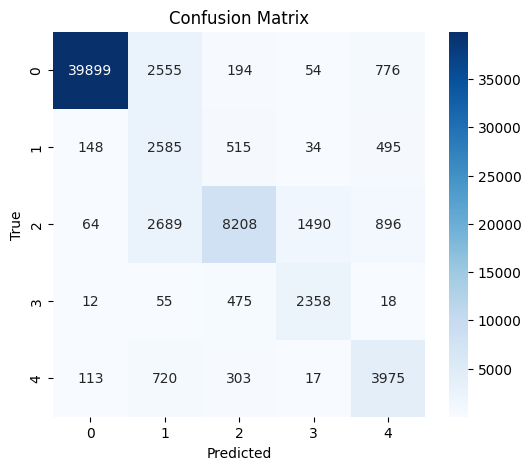

In [28]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
print("Validation Accuracy:", accuracy_score(all_labels, all_preds))

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# **Shap Analysis**

In [ ]:
pip install shap

# 1. import Required Libraries

In [109]:
import shap                          # SHAP library for explainability
import torch                         # PyTorch base library
import torch.nn as nn                # Neural network module container
import torch.nn.functional as F      # Activation functions (e.g., softmax)
import numpy as np                   # Numerical processing
import matplotlib.pyplot as plt      # Plotting library
import seaborn as sns                # Heatmaps (prettier than matplotlib)


# 2. Set Model to Evaluation Mode

In [110]:
model.eval()


DeepSleepNet(
  (conv1): Conv1d(2, 32, kernel_size=(50,), stride=(6,), padding=(25,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(8,), stride=(1,), padding=(4,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(64, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

# 3. Define Class Names

In [111]:
class_names = ["W", "N1", "N2", "N3", "REM"]


# 4. SHAP Model Wrapper (Converts Logits to Probabilities)

In [116]:
class ShapWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        logits = self.base_model(x)           # raw model output (logits)
        return F.softmax(logits, dim=1)       # convert logits → probabilities

    shap_model = ShapWrapper(model).to(device)
    shap_model.eval()


# 5. Select Background and Test Samples

In [117]:
background = X_train_t[:200].to(device)
test_samples = X_test_t[:50].to(device)
test_labels = y_test[:50]


# 6. Create SHAP GradientExplainer

In [118]:
explainer = shap.GradientExplainer(shap_model, background)


In [119]:
print("Calculating SHAP values...")
shap_values_raw = explainer.shap_values(test_samples)


Calculating SHAP values...


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: GRU
  warnings.warn(f"unrecognized nn.Module: {module_type}")


In [120]:
print("len(shap_values_raw):", len(shap_values_raw))
print("Raw SHAP shape for item 0:", np.array(shap_values_raw[0]).shape)


len(shap_values_raw): 50
Raw SHAP shape for item 0: (2, 3000, 5)


# 7. Stack SHAP Values into a Single Tensor

In [121]:
shap_arr = np.stack([np.array(sv) for sv in shap_values_raw], axis=0)
N, C, T, K = shap_arr.shape


# 8. Global Channel Importance

In [122]:
channel_importance = np.mean(np.abs(shap_arr), axis=(0, 2, 3))


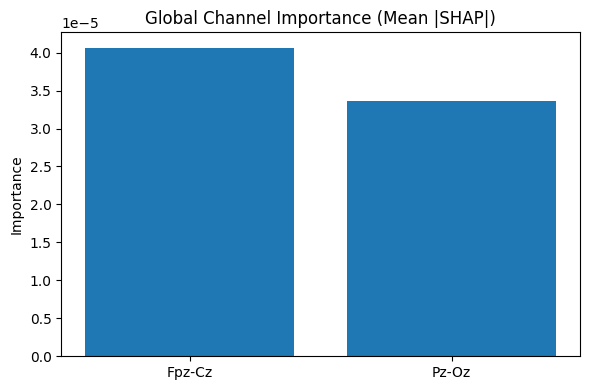

In [123]:
plt.figure(figsize=(6,4))
plt.bar(ch_names, channel_importance)
plt.title("Global Channel Importance (Mean |SHAP|)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


# 9. Global Time Importance

In [124]:
time_importance = np.mean(np.abs(shap_arr), axis=(0, 1, 3))


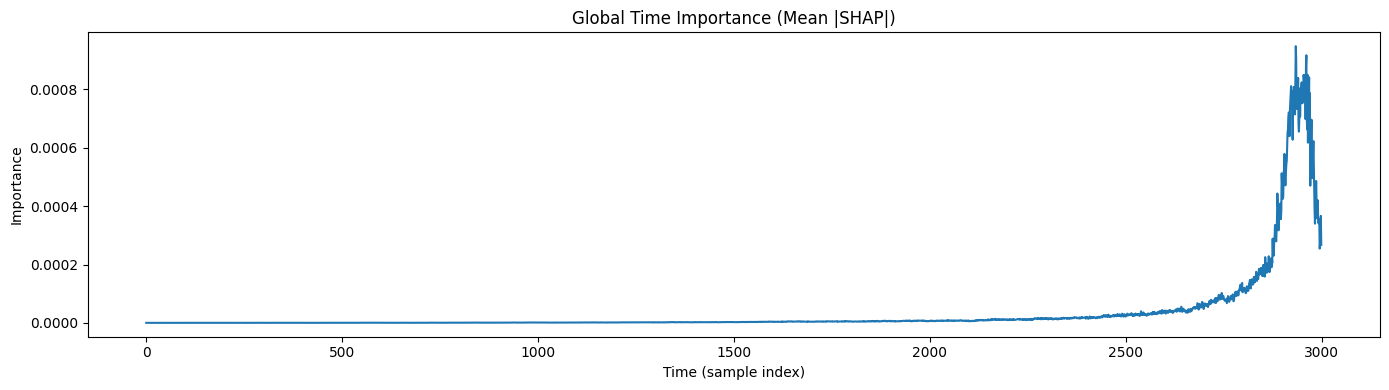

In [125]:
plt.figure(figsize=(14,4))
plt.plot(time_importance)
plt.title("Global Time Importance (Mean |SHAP|)")
plt.xlabel("Time (sample index)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


# 10. Per-Class Mean SHAP Heatmaps

In [126]:
mean_shap_per_class = np.mean(shap_arr, axis=0)  # (C, T, K)


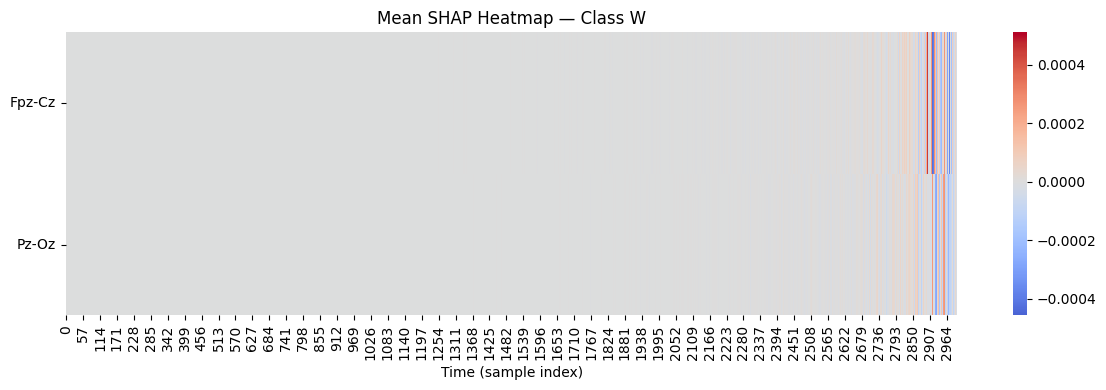

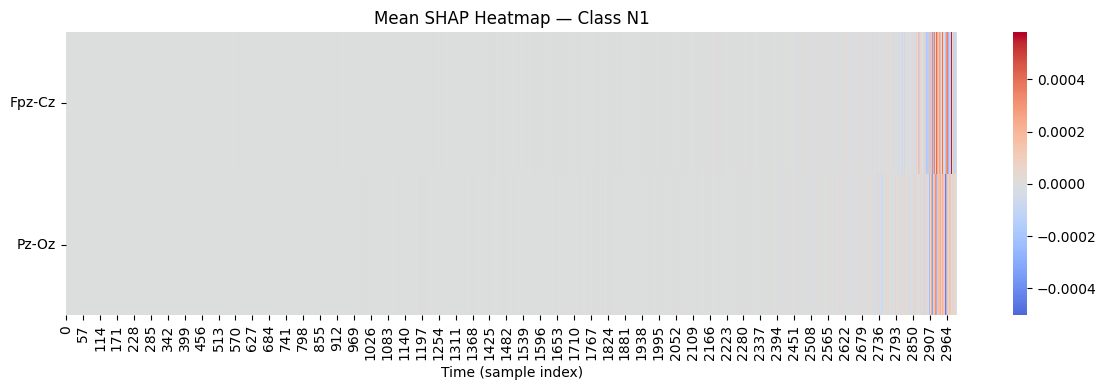

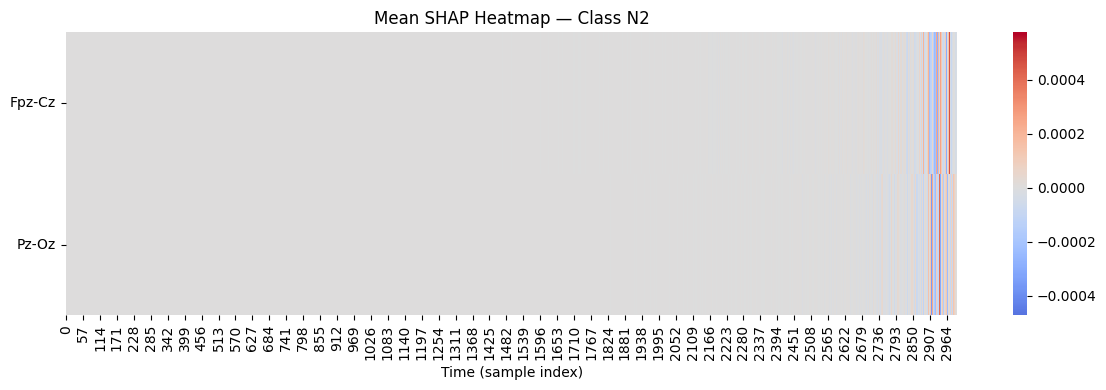

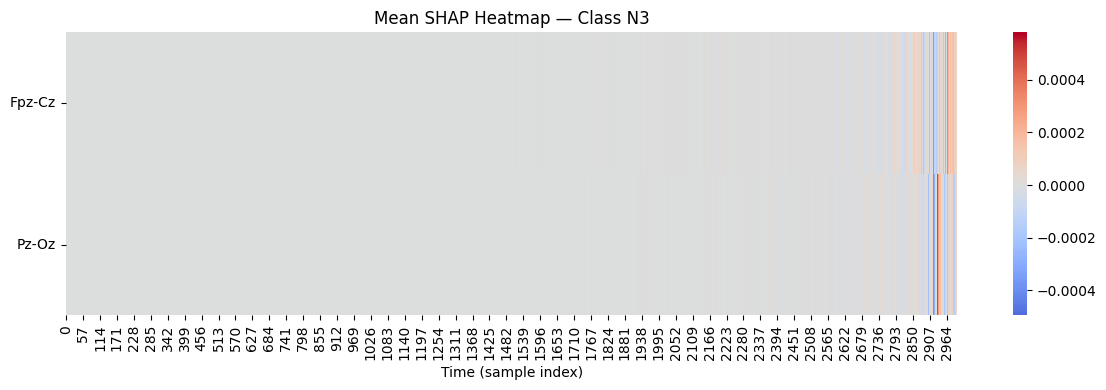

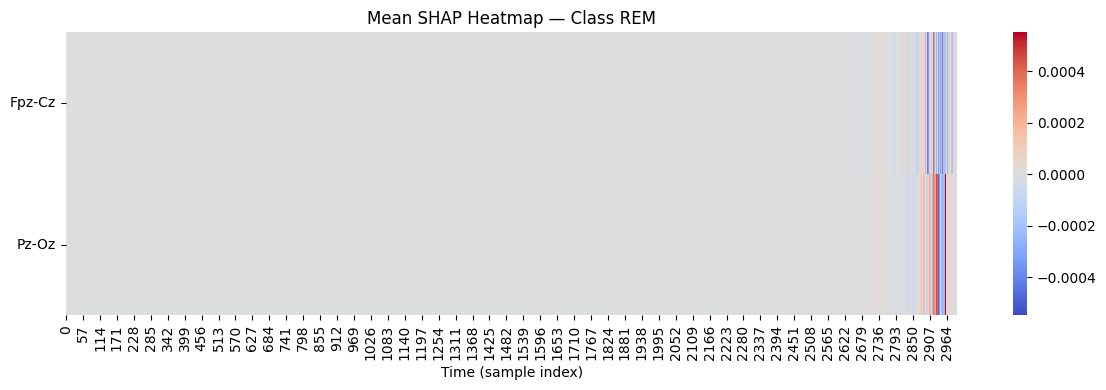

In [141]:
for class_id in range(K):
    plt.figure(figsize=(12,4))
    sns.heatmap(mean_shap_per_class[:, :, class_id],
                cmap="coolwarm", center=0)
    plt.title(f"Mean SHAP Heatmap — Class {class_names[class_id]}")
    plt.yticks([0.5, 1.5], ch_names, rotation=0)
    plt.xlabel("Time (sample index)")
    plt.tight_layout()
    plt.show()


# 11. Per-Sample SHAP Heatmap

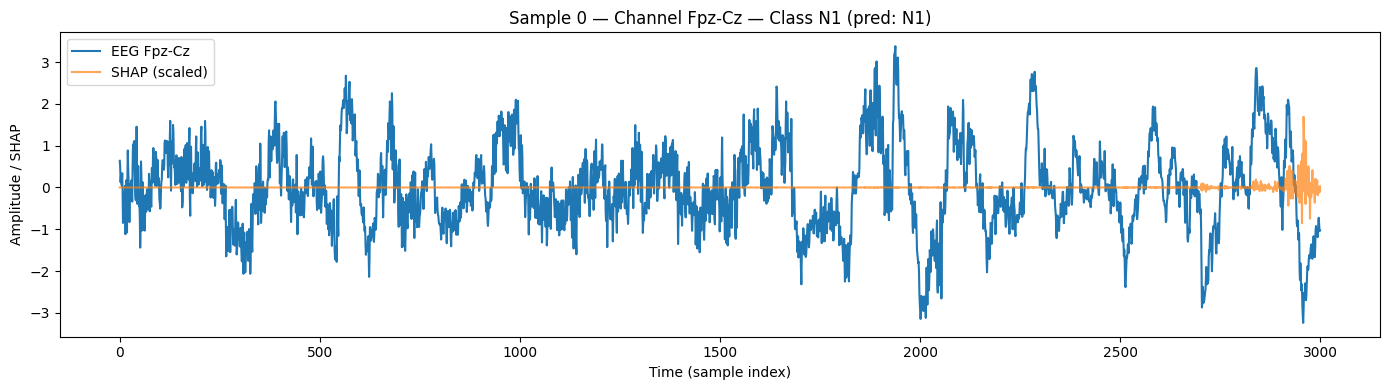

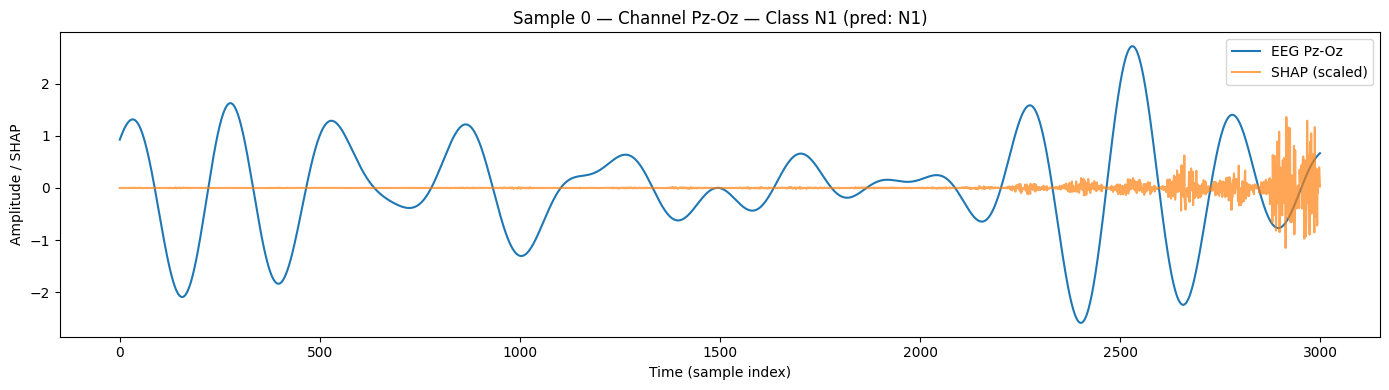

In [142]:


def plot_shap_overlay(sample_idx, class_id=None, scale_shap=True):
    """
    Overlay SHAP values on the raw EEG signal for a given sample.
    If class_id is None, use predicted class.
    scale_shap=True rescales SHAP values to similar range as the signal.
    """
    x = test_samples[sample_idx:sample_idx+1]
    with torch.no_grad():
        probs = shap_model(x).cpu().numpy()[0]
    pred_class = np.argmax(probs)

    if class_id is None:
        class_id = pred_class

    epoch = test_samples[sample_idx].cpu().numpy()       # (C, T)
    sv = shap_arr[sample_idx, :, :, class_id]            # (C, T)

    # Optionally scale SHAP for visualization (so it isn't too small)
    if scale_shap:
        # scale separately per channel
        sv_scaled = np.zeros_like(sv)
        for ch in range(C):
            sig_range = np.max(np.abs(epoch[ch])) + 1e-8
            shap_range = np.max(np.abs(sv[ch])) + 1e-8
            sv_scaled[ch] = sv[ch] * (sig_range / shap_range) * 0.5
    else:
        sv_scaled = sv

    for ch in range(C):
        plt.figure(figsize=(14,4))
        plt.plot(epoch[ch], label=f"EEG {ch_names[ch]}")
        plt.plot(sv_scaled[ch], label="SHAP (scaled)", alpha=0.7)
        plt.title(
            f"Sample {sample_idx} — Channel {ch_names[ch]} — "
            f"Class {class_names[class_id]} (pred: {class_names[pred_class]})"
        )
        plt.xlabel("Time (sample index)")
        plt.ylabel("Amplitude / SHAP")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Example usage:
plot_shap_overlay(0)   # overlay for predicted class of sample 0
